# Plant_Seedlings_Classification

Applying what I learnt so far in fastai in the Kaggle Competetions, was really a fun one indeed. Got stuck while creating a csv file for the submission but somehow with the help of people's in forums got through. 

The Competetions link: https://www.kaggle.com/c/plant-seedlings-classification/overview

In [1]:
from fastai.vision.all import *
from fastai import * 

In [3]:
# The path to the data 

train_data = Path('train/')
test_data = Path('test/')

In [101]:
get_image_files_sorted??

Object `get_image_files_sorted` not found.


In [4]:
# Getting the filenames 

train_fns = get_image_files(train_data)
train_fns

test_fns = get_image_files(test_data)
test_fns

(#794) [Path('test/7e9cf1c46.png'),Path('test/6df8e31ea.png'),Path('test/56112b92c.png'),Path('test/ef65533d5.png'),Path('test/67ce3eaa6.png'),Path('test/4c5ab9b68.png'),Path('test/8a30b2de3.png'),Path('test/86f08e6d1.png'),Path('test/f48916a8c.png'),Path('test/dd5ec63d9.png')...]

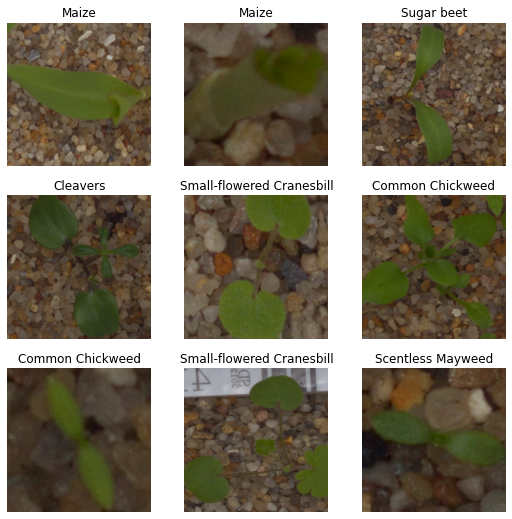

In [6]:
# Building a Data Block 

plant = DataBlock(blocks=(ImageBlock , CategoryBlock) , 
                   get_items=get_image_files,
                   get_y = parent_label, 
                   item_tfms = RandomResizedCrop(460, min_scale=0.75),
                   batch_tfms = [*aug_transforms(size=224, max_warp=0 , max_zoom= 0.8 ), Normalize.from_stats(*imagenet_stats)])

# Creating a Dataloader 

train_dls = plant.dataloaders(train_data , bs = 64)

# Checking how well our data has been formatted 
train_dls.show_batch()

In [7]:
# Getting the Metrics for evaluation 

f1_score = F1Score(average='micro')
precision = Precision(average='micro')
recall = Recall(average='micro')

In [11]:
# Creating a model 

learn = cnn_learner(train_dls, resnet50, pretrained=True, metrics=[error_rate ,f1_score, precision , recall ,accuracy]).to_fp16()

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.002511886414140463)

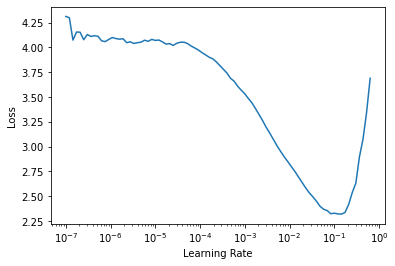

In [12]:
# Finding a learnin rate / freeze 
learn.lr_find()

In [13]:
# Running for 3 epochs / freezed other layers 

learn.fit_one_cycle(3 , 4e-3)

epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,accuracy,time
0,1.245571,0.487559,0.130526,0.869474,0.869474,0.869474,0.869474,01:08
1,0.548972,0.263670,0.092632,0.907368,0.907368,0.907368,0.907368,01:05
2,0.303576,0.199678,0.075789,0.924211,0.924211,0.924211,0.924211,01:05


In [14]:
# Unfreezing other network 
learn.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=3.981071586167673e-06)

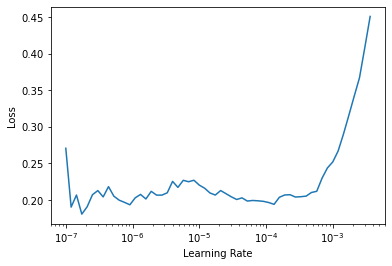

In [15]:
# Again wanna find the learning rate , because we unfreezed all the networks 

learn.lr_find()

In [16]:
# Training the whole network for 10 epochs 

learn.fit_one_cycle(10 , lr_max = slice(6e-5 , 1e-4))

epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,accuracy,time
0,0.176027,0.182589,0.066316,0.933684,0.933684,0.933684,0.933684,01:32
1,0.165459,0.191575,0.061053,0.938947,0.938947,0.938947,0.938947,01:32
2,0.168552,0.216893,0.066316,0.933684,0.933684,0.933684,0.933684,01:33
3,0.145585,0.194841,0.056842,0.943158,0.943158,0.943158,0.943158,01:32
4,0.100002,0.172872,0.050526,0.949474,0.949474,0.949474,0.949474,01:32
5,0.076292,0.158826,0.040000,0.960000,0.960000,0.960000,0.960000,01:33
6,0.051329,0.130222,0.040000,0.960000,0.960000,0.960000,0.960000,01:32
7,0.031060,0.138317,0.030526,0.969474,0.969474,0.969474,0.969474,01:34
8,0.021319,0.138347,0.031579,0.968421,0.968421,0.968421,0.968421,01:32
9,0.014584,0.138709,0.034737,0.965263,0.965263,0.965263,0.965263,01:32


First, I wanna make a submission in Kaggle then let's worry about improving the model

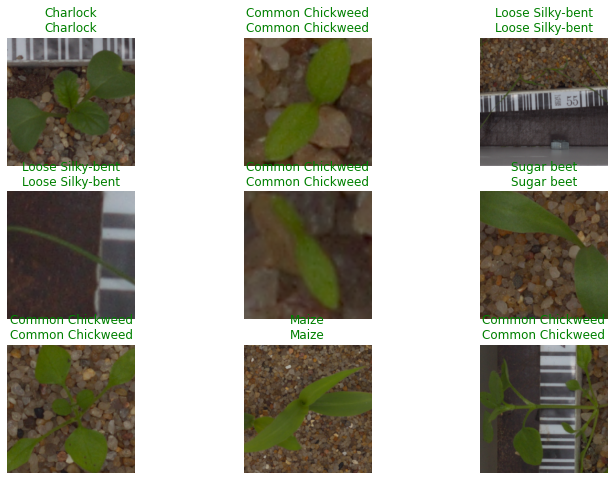

In [21]:
# Checking the results 
learn.show_results(figsize=(12,8))

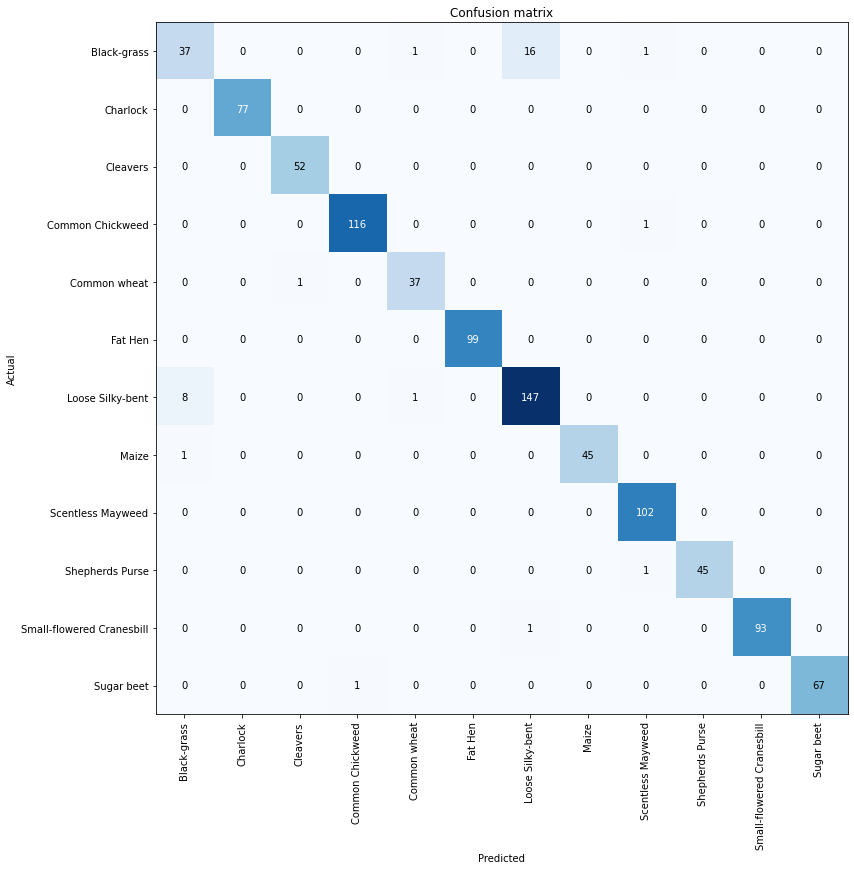

In [20]:
# Confusion Matrix 

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(16,12))

In [22]:
# Creating a test dataloader 

test_dl = train_dls.test_dl(test_fns)

# Getting the predictions for the test set 

test_pred = learn.get_preds(dl = test_dl)
test_pred

(TensorImage([[2.1490e-06, 1.6201e-08, 1.7850e-06,  ..., 4.7459e-04, 9.3142e-06,
          2.9316e-06],
         [4.1584e-10, 9.9890e-01, 1.1302e-10,  ..., 2.3055e-10, 6.2032e-09,
          2.1571e-11],
         [1.7413e-07, 7.3568e-08, 6.8771e-10,  ..., 1.1432e-06, 1.0000e+00,
          1.1630e-09],
         ...,
         [1.5782e-04, 2.4665e-09, 9.4379e-08,  ..., 2.1773e-07, 3.5868e-06,
          1.0861e-08],
         [1.1631e-07, 7.5318e-08, 2.0782e-05,  ..., 1.5659e-04, 3.3319e-09,
          1.3623e-08],
         [1.5606e-08, 2.0939e-08, 6.1981e-08,  ..., 4.9340e-10, 8.7774e-11,
          1.0000e+00]]),
 None)

In [23]:
# Getting in the Sample Submission File 
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet
...,...,...
789,fea355851.png,Sugar beet
790,fea3da57c.png,Sugar beet
791,fef2ade8c.png,Sugar beet
792,ff65bc002.png,Sugar beet


**CAUTION** Below function didn't work for this problem, still it can work for problems like Dog Breed Identification. 

In [32]:
# Let's write helper function for this 

def create_predictions_csv(test_preds, sample_submission):
    
    '''
    INPUT --> Takes in test predictions from a test dataloader, with tuple format and the sample submission csv file
    
    OUTPUT --> Return the test dataframe of results
    
    '''
    
    import pandas as pd 
    sample_sub = sample_submission
    test_pred = test_preds[0].numpy()
    test_df = pd.DataFrame(test_pred)
    
    df_test = pd.concat([sample_sub['file'],test_df],axis=1)
    return df_test
                        
    
df_test = create_predictions_csv(test_preds=test_pred , sample_submission=sample_sub)    
df_test    
    

,file,0,1,2,3,4,5,6,7,8,9,10,11
0,0021e90e4.png,2.148961e-06,1.620054e-08,1.785034e-06,9.992790e-01,5.209988e-07,1.990000e-04,6.332789e-08,2.490777e-05,5.697812e-06,4.745873e-04,9.314173e-06,2.931550e-06
1,003d61042.png,4.158449e-10,9.989012e-01,1.130215e-10,1.967565e-12,1.549816e-08,8.681305e-12,1.231638e-10,1.098731e-03,5.573157e-11,2.305502e-10,6.203240e-09,2.157053e-11
2,007b3da8b.png,1.741273e-07,7.356831e-08,6.877064e-10,1.323595e-06,5.301403e-08,2.290412e-09,2.507317e-08,8.568287e-09,2.993101e-09,1.143241e-06,9.999973e-01,1.162994e-09
3,0086a6340.png,1.800747e-01,1.612975e-06,4.861983e-07,9.133663e-06,2.145208e-06,7.636328e-05,8.197477e-01,1.657440e-07,8.476179e-06,4.070281e-07,6.745620e-05,1.136148e-05
4,00c47e980.png,2.183932e-09,6.908401e-09,7.235328e-10,2.245782e-10,3.917354e-09,3.111876e-10,4.042828e-10,2.379333e-09,1.951169e-10,2.282170e-07,9.999998e-01,1.216069e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,fea355851.png,9.994237e-01,1.107432e-06,1.721937e-06,3.410620e-07,6.851438e-05,1.696322e-05,2.580660e-04,3.187294e-06,3.827182e-07,7.655987e-07,2.237741e-04,1.404032e-06
790,fea3da57c.png,3.331799e-07,4.163963e-05,3.005502e-04,2.091416e-06,9.435960e-07,4.625054e-08,5.882730e-06,1.627207e-06,9.859076e-01,1.373744e-02,9.199392e-07,1.071325e-06
791,fef2ade8c.png,1.578169e-04,2.466461e-09,9.437873e-08,4.416129e-06,1.010409e-08,9.696213e-07,9.998312e-01,3.100147e-08,1.702570e-06,2.177295e-07,3.586783e-06,1.086130e-08
792,ff65bc002.png,1.163135e-07,7.531796e-08,2.078186e-05,3.540439e-08,1.010398e-08,9.526117e-11,2.636961e-06,4.991328e-10,9.998199e-01,1.565870e-04,3.331939e-09,1.362297e-08


In [35]:
test_d = df_test.drop('file' , axis=1 )


In [40]:
t_b = df_test.drop('file' , axis=1 )

In [37]:
# COnverting to numpy 
test_d = test_d.to_numpy()

In [26]:
# Checking the index

tr_list = list(train_dls.vocab)
idx = 0
for i in tr_list:
    print(f'{i}: {idx}')
    idx+= 1

Black-grass: 0
Charlock: 1
Cleavers: 2
Common Chickweed: 3
Common wheat: 4
Fat Hen: 5
Loose Silky-bent: 6
Maize: 7
Scentless Mayweed: 8
Shepherds Purse: 9
Small-flowered Cranesbill: 10
Sugar beet: 11


In [61]:
mapping={0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5 : 'Fat Hen',
 6 : 'Loose Silky-bent',
 7 : 'Maize',
 8 : 'Scentless Mayweed',
 9 : 'Shepherds Purse',
 10 : 'Small-flowered Cranesbill',
 11: 'Sugar beet'}
mapping

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

In [64]:
col_df = col_df.rename(columns=mapping)
df_test = pd.concat([df_test['file'] , col_df] , axis = 1)
df_test

,file,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherds Purse,Small-flowered Cranesbill,Sugar beet
0,0021e90e4.png,2.148961e-06,1.620054e-08,1.785034e-06,9.992790e-01,5.209988e-07,1.990000e-04,6.332789e-08,2.490777e-05,5.697812e-06,4.745873e-04,9.314173e-06,2.931550e-06
1,003d61042.png,4.158449e-10,9.989012e-01,1.130215e-10,1.967565e-12,1.549816e-08,8.681305e-12,1.231638e-10,1.098731e-03,5.573157e-11,2.305502e-10,6.203240e-09,2.157053e-11
2,007b3da8b.png,1.741273e-07,7.356831e-08,6.877064e-10,1.323595e-06,5.301403e-08,2.290412e-09,2.507317e-08,8.568287e-09,2.993101e-09,1.143241e-06,9.999973e-01,1.162994e-09
3,0086a6340.png,1.800747e-01,1.612975e-06,4.861983e-07,9.133663e-06,2.145208e-06,7.636328e-05,8.197477e-01,1.657440e-07,8.476179e-06,4.070281e-07,6.745620e-05,1.136148e-05
4,00c47e980.png,2.183932e-09,6.908401e-09,7.235328e-10,2.245782e-10,3.917354e-09,3.111876e-10,4.042828e-10,2.379333e-09,1.951169e-10,2.282170e-07,9.999998e-01,1.216069e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,fea355851.png,9.994237e-01,1.107432e-06,1.721937e-06,3.410620e-07,6.851438e-05,1.696322e-05,2.580660e-04,3.187294e-06,3.827182e-07,7.655987e-07,2.237741e-04,1.404032e-06
790,fea3da57c.png,3.331799e-07,4.163963e-05,3.005502e-04,2.091416e-06,9.435960e-07,4.625054e-08,5.882730e-06,1.627207e-06,9.859076e-01,1.373744e-02,9.199392e-07,1.071325e-06
791,fef2ade8c.png,1.578169e-04,2.466461e-09,9.437873e-08,4.416129e-06,1.010409e-08,9.696213e-07,9.998312e-01,3.100147e-08,1.702570e-06,2.177295e-07,3.586783e-06,1.086130e-08
792,ff65bc002.png,1.163135e-07,7.531796e-08,2.078186e-05,3.540439e-08,1.010398e-08,9.526117e-11,2.636961e-06,4.991328e-10,9.998199e-01,1.565870e-04,3.331939e-09,1.362297e-08


In [55]:
col_df = df_test.drop('file' , axis=1)

In [56]:
columns_list = []
for col in col_df.columns:
    columns_list.append(col)
columns_list    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [38]:
import numpy as np

In [66]:
real_pred = np.argmax(test_d , axis = 1)
real_pred

array([ 3,  1, 10,  6, 10,  2, 11,  5,  8, 11, 10,  9,  9,  8,  6,  7,  6,
       11,  3,  1, 11,  6, 11,  1,  8,  3,  8,  9,  5,  1,  5,  5, 10,  3,
        3, 11,  7,  5,  2,  3,  2,  3,  3,  1, 11,  6,  9,  4,  3,  9,  6,
       10,  6,  8,  1, 11,  4,  9,  7,  9,  6,  2, 10, 11,  9,  1,  3,  6,
        2,  1, 11, 11, 10,  1,  8, 11,  8,  3, 10,  2,  1,  4,  6, 10,  5,
       10,  0,  7,  8,  5, 11,  3, 10,  6,  0,  6, 10,  1,  6,  6,  1,  6,
        5,  6,  3,  1,  1,  0,  3,  9,  8,  3,  1,  1,  6,  6,  1,  8, 10,
        8,  8,  0,  7,  6, 11, 11, 11,  6,  6,  6,  6,  4,  6,  6, 11,  8,
        7, 11,  9,  3, 10,  2, 11, 10,  4,  1,  3,  5,  2, 11,  5,  9,  3,
        1,  6, 10,  6,  5,  9,  3,  9,  8,  8, 11,  1,  6,  3,  3, 11,  1,
        6, 11,  1, 10,  2,  0,  3,  2,  6, 11,  3,  6,  7,  6, 10,  5,  1,
        6,  1,  5, 11, 10,  8,  9,  1, 11,  6,  6, 11,  3,  1,  6,  3,  2,
       10,  7,  5,  1,  3,  3,  6,  5,  5,  3,  3,  7,  4,  8, 11,  3,  3,
        6, 11,  8,  6,  5

In [86]:
test_dl.items

Path('test/7e9cf1c46.png')

In [132]:
# Creating csv in 3 lines, learnt a new trick

test_pred_max = test_pred[0].argmax(dim=1)
pred_labels = [train_dls.vocab[o] for o in test_pred_max]
sub = pd.DataFrame({'file':test_dl.items,'species':pred_labels})
sub

,file,species
0,test/7e9cf1c46.png,Common Chickweed
1,test/6df8e31ea.png,Charlock
2,test/56112b92c.png,Small-flowered Cranesbill
3,test/ef65533d5.png,Loose Silky-bent
4,test/67ce3eaa6.png,Small-flowered Cranesbill
...,...,...
789,test/0a64e3e6c.png,Black-grass
790,test/bea23d9f8.png,Scentless Mayweed
791,test/02cfeb38d.png,Loose Silky-bent
792,test/a85b48a95.png,Scentless Mayweed


In [145]:
sub['file'] = sub['file'].astype(str).str.replace('test/' , '')
sub

,file,species
0,7e9cf1c46.png,Common Chickweed
1,6df8e31ea.png,Charlock
2,56112b92c.png,Small-flowered Cranesbill
3,ef65533d5.png,Loose Silky-bent
4,67ce3eaa6.png,Small-flowered Cranesbill
...,...,...
789,0a64e3e6c.png,Black-grass
790,bea23d9f8.png,Scentless Mayweed
791,02cfeb38d.png,Loose Silky-bent
792,a85b48a95.png,Scentless Mayweed


In [146]:
sub.to_csv('submission.csv' , index=False)

Was able to bag `97%` accuracy with just one shot, at first there was filenames mismatch which pulled my score off very low. After going on a hunt googling and checking on forums, I was able to solve this from a member (Issac) in the forum. 

I learnt how to ask clear questions which could results in the answer we been looking for. 